In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression,LogisticRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import entropy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import xgboost as xgb

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


from collections import Counter
from sklearn.metrics import roc_curve, auc,accuracy_score
import pickle
from sklearn.decomposition import PCA

from datetime import datetime


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Import Data

In [72]:
btc_min_return = pd.read_csv('btc_min_return_selected.csv')
btc_min_return.index =pd.to_datetime(btc_min_return['timestamp'])
btc_min_return.drop(columns=['timestamp'],inplace=True)
btc_min_return=btc_min_return[btc_min_return.index > '2019']
btc_min_return['return_scaled'] = btc_min_return['return']*100
print(btc_min_return.columns)

features = btc_min_return.columns.to_list()
features.remove('return')
features.remove('return_scaled')
features.remove('J_test_stats')
TI_features = features[:6]+features[-17:]
SV_features = features[:-17]
Naive_features = features[:6]

Index(['open', 'high', 'low', 'number_of_trades', 'close', 'return', 'volume',
       'jump_detected_1_3', 'jump_size_1_3', 'jump_detected_2_3',
       'jump_size_2_3', 'jump_detected_3_3', 'jump_size_3_3',
       'jump_detected_1_1', 'jump_size_1_1', 'jump_detected_2_1',
       'jump_size_2_1', 'RV_d', 'log1+J', 'sigma2_hat', 'shape_left',
       'scale_left', 'shape_right', 'scale_right', 'RS_neg', 'RS_pos', 'BPV',
       'RS', 'JP', 'J_test_stats', 'BPV_test_jump',
       'rolling_mean_return_15min', 'rolling_std_return_15min',
       'rolling_mean_volume_15min', 'rolling_std_volume_15min',
       'return_lag_1min', 'return_lag_5min', 'return_lag_10min',
       'return_lag_15min', 'return_volume_interaction', 'ema_return_5min',
       'hist_vol_5min', 'macd', 'macd_signal', 'rsi', 'bollinger_hband',
       'bollinger_lband', 'atr', 'return_scaled'],
      dtype='object')


### Generate labels

In [289]:
quantile_upper = 0.66
quantile_lower = 1-quantile_upper
accuracy_metric = 'Build_in_acc'
target_used = 'target_quantile'

In [168]:
# Create the target variable -- Quantile based threshold
upper_quantile = btc_min_return['return_scaled'].quantile(quantile_upper)
lower_quantile = btc_min_return['return_scaled'].quantile(quantile_lower)
btc_min_return['target_quantile'] = 0
btc_min_return.loc[btc_min_return['return_scaled'].shift(-1) > upper_quantile, 'target_quantile'] = 1
btc_min_return.loc[btc_min_return['return_scaled'].shift(-1) < lower_quantile, 'target_quantile'] = -1
btc_min_return = btc_min_return.dropna()
print([upper_quantile,lower_quantile])

[0.04844716058581401, -0.048522686341571995]


8.352861111111112
Upper bound of the threshold value: 0.10501117891453493
Lower bound of the threshold value: -0.04238739095866517


Text(0, 0.5, 'Count')

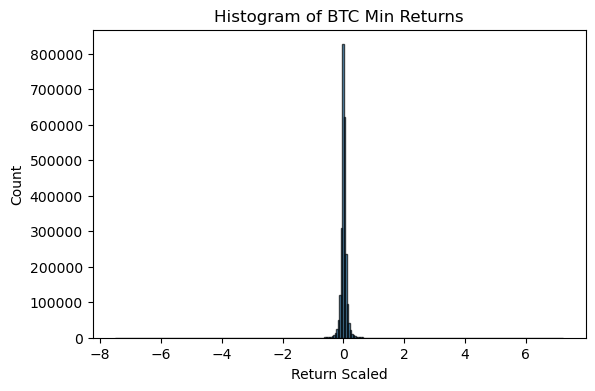

In [125]:
print(len(btc_min_return)/200/60/24) # roughly ten days per bin
number_of_bins = 300
bin_counts, bin_edges = np.histogram(btc_min_return['return_scaled'], bins=number_of_bins)

sorted_indices = np.argsort(bin_counts)[::-1]
sorted_bin_counts = bin_counts[sorted_indices]
sorted_bin_edges = bin_edges[sorted_indices]

original_bin_edges = bin_edges
cumulative_counts = np.cumsum(sorted_bin_counts)
total_count = len(btc_min_return)  
threshold_count_upper = 0.8 * total_count
threshold_count_lower = 0.2 * total_count

threshold_bin_index_upper = np.where(cumulative_counts >= threshold_count_upper)[0][0]
threshold_upper_bound = original_bin_edges[sorted_indices[threshold_bin_index_upper] + 1] if threshold_bin_index_upper < len(original_bin_edges) - 1 else original_bin_edges[-1]
threshold_bin_index_lower = np.where(cumulative_counts >= threshold_count_lower)[0][0]
threshold_lower_bound = original_bin_edges[sorted_indices[threshold_bin_index_lower]]
print(f'Upper bound of the threshold value: {threshold_upper_bound}')
print(f'Lower bound of the threshold value: {threshold_lower_bound}')

btc_min_return['target_hist'] = 0
btc_min_return.loc[btc_min_return['return_scaled'].shift(-1) > threshold_upper_bound, 'target_hist'] = 1
btc_min_return.loc[btc_min_return['return_scaled'].shift(-1) < threshold_lower_bound, 'target_hist'] = -1
btc_min_return = btc_min_return.dropna()

# Plotting
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.hist(btc_min_return['return_scaled'], bins=number_of_bins, edgecolor='k', alpha=0.7)
plt.title('Histogram of BTC Min Returns')
plt.xlabel('Return Scaled')
plt.ylabel('Count')

In [126]:
# Function to calculate entropy
def calculate_entropy(labels):
    label_counts = np.bincount(labels.astype(int))
    return entropy(label_counts, base=2)

def calculate_best_thresholds(close_diff, threshold_upper_bound):
    best_entropy_upper = -np.inf
    best_threshold_upper = 0

    # Upper threshold search
    temp_threshold = 0
    while temp_threshold < threshold_upper_bound:
        labels = np.zeros(len(close_diff))
        indexes_incr = np.where(close_diff > temp_threshold)[0]
        indexes_decr = np.where(-close_diff > temp_threshold)[0]

        labels[indexes_incr] = 2
        labels[indexes_decr] = 1

        current_entropy = calculate_entropy(labels)

        if current_entropy > best_entropy_upper:
            best_entropy_upper = current_entropy
            best_threshold_upper = temp_threshold

        temp_threshold += 0.00001

    return best_threshold_upper

# Applying the algorithm
Entropy_upper_threshold = calculate_best_thresholds(btc_min_return['return_scaled'], threshold_upper_bound)
print([Entropy_upper_threshold, -Entropy_upper_threshold])

[0.020779999999999323, -0.020779999999999323]


In [169]:
btc_min_return['target_entropy'] = 0
btc_min_return.loc[btc_min_return['return_scaled'].shift(-1) > Entropy_upper_threshold, 'target_entropy'] = 1
btc_min_return.loc[btc_min_return['return_scaled'].shift(-1) < -Entropy_upper_threshold, 'target_entropy'] = -1
btc_min_return = btc_min_return.dropna()

In [290]:
df = btc_min_return.copy()
X = df[features]
y = df[target_used]

# Split the data into training and test sets
cutoff_date = '2022-01-01'
X_train = X[btc_min_return.index < cutoff_date]
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = X[btc_min_return.index >= cutoff_date]
scaler = StandardScaler()
X_test= scaler.fit_transform(X_test)
y_train = y[btc_min_return.index < cutoff_date]
y_test = y[btc_min_return.index >= cutoff_date]


In [291]:
X_TI = df[TI_features]
X_train_TI = X_TI[df[TI_features].index < cutoff_date]
scaler = StandardScaler()
X_train_TI= scaler.fit_transform(X_train_TI)
X_test_TI = X_TI[df[TI_features].index >= cutoff_date]
scaler = StandardScaler()
X_test_TI= scaler.fit_transform(X_test_TI)

X_SV = df[SV_features]
scaler = StandardScaler()
X_SV= scaler.fit_transform(X_SV)
X_train_SV = X_SV[df[SV_features].index < cutoff_date]
X_test_SV = X_SV[df[SV_features].index >= cutoff_date]

X_Naive = df[Naive_features]
scaler = StandardScaler()
X_Naive= scaler.fit_transform(X_Naive)
X_train_Naive = X_Naive[df[Naive_features].index < cutoff_date]
X_test_Naive = X_Naive[df[Naive_features].index >= cutoff_date]

### Define Accuracy metrics

- Type I error: FP (reject null while null is true)

- Type II error: FN (not reject null while null is not true)

- Precision: $\frac{TP}{TP + FP}$

- Recall: $\frac{TP}{TP + FN}$

- F1-Score: $2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

- Accuracy_function:

$\text{Profit}-\text{accuracy} = \frac{TD + TI}{TD + TI + FDN+FIN+FID+FDI}$;

s.t.
TD: the number of true predictions decreases; FDN: the number of predictions of the no-action class decreases; FDI: the number of predictions of the increase class decreases and etc.




In [303]:
def custom_accuracy(y_true, y_pred):
    Accuracy = {}
    
    # Acc_Ignore_Pred_Neutral: Accuracy when ignoring neutral predictions
    mask_pred_non_neutral = y_pred != 0
    correct_pred_non_neutral = (y_true[mask_pred_non_neutral] == y_pred[mask_pred_non_neutral]).sum()
    total_pred_non_neutral = mask_pred_non_neutral.sum()
    Accuracy['Acc_Ignore_Pred_Neutral'] = (
        correct_pred_non_neutral / total_pred_non_neutral 
        if total_pred_non_neutral > 0 
        else 0
    )
    
    # Acc_Ignore_True_Neutral: Accuracy when ignoring neutral true labels
    mask_true_non_neutral = y_true != 0
    correct_true_non_neutral = (y_true[mask_true_non_neutral] == y_pred[mask_true_non_neutral]).sum()
    total_true_non_neutral = mask_true_non_neutral.sum()
    Accuracy['Acc_Ignore_True_Neutral'] = (
        correct_true_non_neutral / total_true_non_neutral 
        if total_true_non_neutral > 0 
        else 0
    )
    
    # Acc_True: Standard accuracy
    Accuracy['Acc_True'] = accuracy_score(y_true, y_pred)
    
    # Round the accuracy values to 2 decimal places
    Acc = {k: round(v, 2) for k, v in Accuracy.items()}
    
    # Return the accuracies as a DataFrame
    return pd.DataFrame([Acc])


### Benchmark Model: Logistic Regression Model

In [135]:
def plot_confusion_matrix(y_true, y_pred, class_names,model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob, class_names,model_name):
    y_true_bin = label_binarize(y_true, classes=[-1, 0, 1])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i, class_label in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_prob[:, i])

    plt.figure(figsize=(4, 3))
    for i, class_label in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[class_label]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model, model_name,n=None):
    if n is not None:
        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    else:
        X_train_pca, X_test_pca = X_train, X_test

    model.fit(X_train_pca, y_train)

    # Predict discrete labels
    y_pred = model.predict(X_test_pca)

    # Generate classification report
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    print(report_df)

    # Compute custom accuracy
    custom_acc = custom_accuracy(y_test, y_pred)
    print(custom_acc)

    # Plot confusion matrix
    class_names = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
    plot_confusion_matrix(y_test, y_pred, list(class_names.values()),model_name)

    # Compute probabilities for ROC curve
    y_pred_prob = model.predict_proba(X_test_pca)

    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_prob, class_names,model_name)

              precision    recall  f1-score        support
-1             0.377704  0.024434  0.045898  134363.000000
0              0.718564  0.683307  0.700492  563359.000000
1              0.194830  0.418039  0.265787  133820.000000
accuracy       0.534155  0.534155  0.534155       0.534155
macro avg      0.430366  0.375260  0.337393  831542.000000
weighted avg   0.579202  0.534155  0.524764  831542.000000
   Acc_Ignore_Pred_Neutral  Acc_Ignore_True_Neutral  Acc_True
0                      0.2                     0.22      0.53


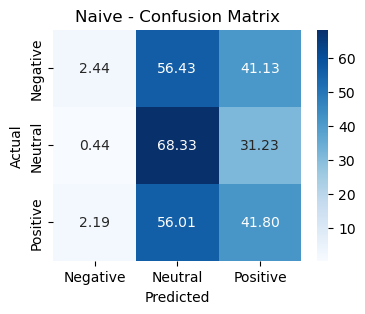

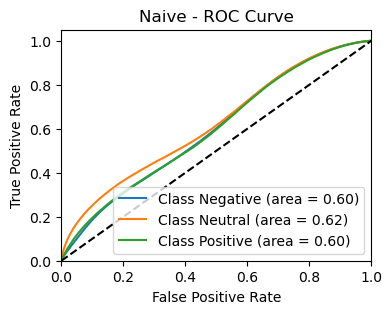

In [292]:
model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
train_and_evaluate_model(X_train_Naive, y_train, X_test_Naive, y_test, model,'Naive')

              precision    recall  f1-score        support
-1             0.356669  0.157134  0.218157  134363.000000
0              0.736274  0.932633  0.822902  563359.000000
1              0.353381  0.155126  0.215606  133820.000000
accuracy       0.682201  0.682201  0.682201       0.682201
macro avg      0.482108  0.414964  0.418888  831542.000000
weighted avg   0.613317  0.682201  0.627453  831542.000000
   Acc_Ignore_Pred_Neutral  Acc_Ignore_True_Neutral  Acc_True
0                     0.36                     0.16      0.68


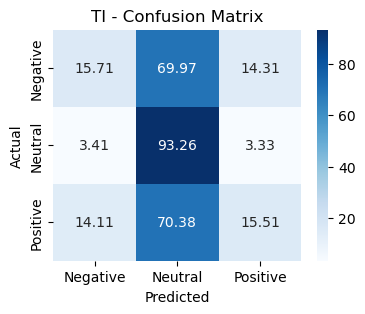

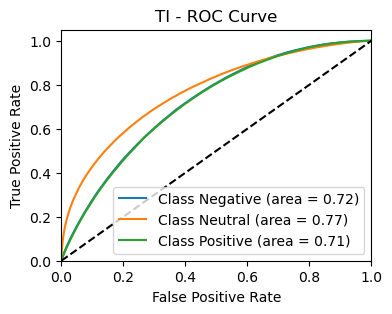

In [293]:
train_and_evaluate_model(X_train_TI, y_train, X_test_TI, y_test, model,'TI',n=20)

              precision    recall  f1-score       support
-1             0.281465  0.089928  0.136306  134363.00000
0              0.732413  0.819122  0.773345  563359.00000
1              0.249182  0.295247  0.270266  133820.00000
accuracy       0.616990  0.616990  0.616990       0.61699
macro avg      0.421020  0.401433  0.393306  831542.00000
weighted avg   0.581781  0.616990  0.589450  831542.00000
   Acc_Ignore_Pred_Neutral  Acc_Ignore_True_Neutral  Acc_True
0                     0.26                     0.19      0.62


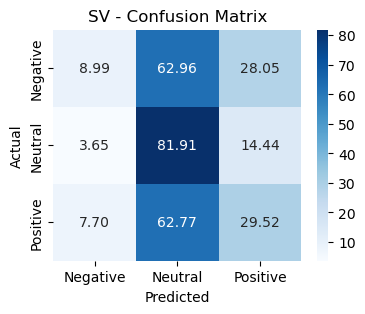

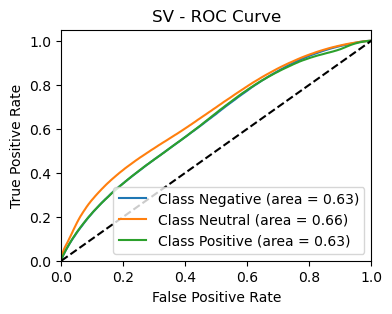

In [294]:
train_and_evaluate_model(X_train_SV, y_train, X_test_SV, y_test, model,'SV',n=20)

### ML model: SLTM

- In comparison with stock market, crypto is a special financial market that entails both high risks and high profit opportunities. Like stock, trading in cryptocurrencies often involves predicting the direction of the price movement (up or down). Traders can profit from buying low and selling high or short-selling high and buying back lower.

- In this work, we used a popular deep learning tool called “long short-term memory” (LSTM), which has been shown to be very effective in many time-series forecasting problems, to make direction predictions in crypto and stock markets. 

- In recent years, deep learning tools, such as long short-term memory (LSTM), have become popular and have been found to be effective for many time-series forecasting problems. In general, such problems focus on determining the future values of time- series data with high accuracy. However, in direction prediction problems, accuracy can- not be defined as simply the difference between actual and predicted values. Therefore, a novel rule-based decision layer needs to be added after obtaining predictions from LSTMs.

- Baseline LSTMs: As a baseline, SV-LSTM and TI-LSTM were tested separately. Also, by combining all of the features of these two into a single model, we generated a third baseline model: SV-TI-LSTM.

- Proposed hybrid LSTM model: Our proposed model does not combine the features of the two baseline LSTMs into a single model. Instead, we propose a rule-based decision mechanism that acts as a kind of postprocessing; it is used to combine the results of the baselines into a final decision.

- Model set up: The training phase was carried out with different numbers of iterations (50, 100, and 150); Only when a difference between two consecutive data points is greater/less than the threshold will the next data point be labeled as increase/decrease; 

- Post-processing rule: if any model's prediction is class-noact, the final decision is class-noact; if both models agree on the label, set the final decision as the label; if the predictions of the two models are different, let the final decision the one whose predition has higher prob, if the prob is the same set the prediction of the TI-LSTM model --> this is a conservative approach as it reduces the number of trades and favors only high-accuracy predictions. 

In [300]:
class CustomAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super(CustomAccuracyCallback, self).__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.custom_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        # Predict the probabilities
        y_pred_prob = self.model.predict(self.X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        # Compute the custom accuracy
        custom_acc_df = custom_accuracy(self.y_val, y_pred)
        
        # Extract the custom accuracy value for "Acc_Ignore_Pred_Neutral"
        acc_true = custom_acc_df.loc[0, 'Acc_True']
        
        # Log the custom accuracy value
        logs['custom_acc_true'] = acc_true
        
        # Save custom accuracy value to list
        self.custom_accuracies.append({
            'Epoch': epoch + 1,
            'Acc_True': acc_true
        })
        
        print(f'Epoch {epoch + 1}: Acc_True = {acc_true:.2f}')

    def on_train_end(self, logs=None):
        # Convert custom accuracies to DataFrame at the end of training
        self.custom_accuracies_df = pd.DataFrame(self.custom_accuracies)
        print("Custom accuracy DataFrame:\n", self.custom_accuracies_df)



def build_and_train_lstm_with_autoencoder(X_train, y_train, X_test, y_test, encoding_dim=32, epochs=50, patience=5):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    input_dim = X_train_scaled.shape[1]
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(encoding_dim*2, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(encoding_dim*2, activation='relu')(encoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    
    # Autoencoder
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    #custom_acc_callback = CustomAccuracyCallback(X_test_scaled, y_test_encoded)
    autoencoder.fit(X_train_scaled, X_train_scaled, 
                    epochs=epochs, 
                    batch_size=64, 
                    shuffle=True, 
                    verbose=2, 
                    validation_data=(X_test_scaled, X_test_scaled),
                    callbacks=[early_stopping])

    encoder = Model(inputs=input_layer, outputs=encoded)
    X_train_encoded = encoder.predict(X_train_scaled)
    X_test_encoded = encoder.predict(X_test_scaled)
    X_train_lstm = np.reshape(X_train_encoded, (X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
    X_test_lstm = np.reshape(X_test_encoded, (X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

    model = Sequential()
    model.add(Input(shape=(1, X_train_encoded.shape[1])))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    custom_acc_callback = CustomAccuracyCallback(X_test_lstm, y_test_encoded)
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )

    model.fit(X_train_lstm, y_train_encoded,
              epochs=epochs,
              batch_size=64,
              verbose=2,
              validation_data=(X_test_lstm, y_test_encoded),
              callbacks=[custom_acc_callback, early_stopping_callback])

    y_pred_prob = model.predict(X_test_lstm)
    y_pred_encoded = np.argmax(y_pred_prob, axis=1)
    y_pred_class = label_encoder.inverse_transform(y_pred_encoded)

    return y_pred_prob, y_pred_class, custom_acc_callback.custom_accuracies_df


In [301]:
def evaluate_lstm_model(X_train, y_train, X_test, y_test, epochs_list):
    results = {}
    
    for epochs in epochs_list:
        print(f'\nTraining with {epochs} epochs...\n')

        # Train the LSTM model with the specified number of epochs
        y_pred_prob, y_pred_class, custom_accuracies_df = build_and_train_lstm_with_autoencoder(
            X_train, y_train, X_test, y_test, epochs=epochs
        )

        # Manually calculate custom accuracy (assuming the function takes y_true and y_pred as np arrays)
        custom_acc = custom_accuracy(y_test, y_pred_class)
        print(custom_acc)
        
        # Store results
        results[epochs] = {
            'custom_acc': custom_acc,
            'y_pred_prob': y_pred_prob,
            'y_pred_class': y_pred_class,
            'custom_accuracies_df': custom_accuracies_df
        }
    
    return results



def create_hybrid_predictions(y_pred_class_SV, y_pred_prob_SV, y_pred_class_TI, y_pred_prob_TI):
    final_predictions = []
    final_probabilities = []

    for pred_SV, prob_SV, pred_TI, prob_TI in zip(y_pred_class_SV, y_pred_prob_SV, y_pred_class_TI, y_pred_prob_TI):
        if pred_SV == 0 and pred_TI == 0:
            # If either model predicts class-noact (0), the final decision is class-noact (0)
            final_predictions.append(0)
            final_probabilities.append(prob_SV)  # No active probabilities
        elif pred_SV == pred_TI:
            # If both models agree on the label, use that label
            final_predictions.append(pred_SV)
            final_probabilities.append(prob_SV)  
        else:
            # If predictions are different, compare the probabilities for the predicted classes
            prob_SV_pred = prob_SV[np.argmax(prob_SV)]  # Probability for the class predicted by SV
            prob_TI_pred = prob_TI[np.argmax(prob_TI)]  # Probability for the class predicted by TI
            
            if prob_SV_pred > prob_TI_pred:
                final_predictions.append(pred_SV)
                final_probabilities.append(prob_SV)
            elif prob_SV_pred < prob_TI_pred:
                final_predictions.append(pred_TI)
                final_probabilities.append(prob_TI)
            else:
                # If probabilities are the same, choose the SV model's prediction
                final_predictions.append(pred_SV)
                final_probabilities.append(prob_SV)
    
    return np.array(final_predictions), np.array(final_probabilities)

def create_results_summary(y_test, results, custom_accuracy_func, epochs):
    # Initialize a dictionary to store the custom accuracy DataFrames for each model
    custom_acc_dfs = {model: [] for model in results.keys()}

    # Calculate custom accuracies for each model and epoch
    for model_name, model_results in results.items():
        for epoch in epochs:
            y_pred_class = model_results[epoch]['y_pred_class']
            custom_acc_dfs[model_name].append(custom_accuracy_func(y_test, y_pred_class))

    # Concatenate the DataFrames across epochs for each model
    custom_acc_df_dict = {}
    for model_name, acc_dfs in custom_acc_dfs.items():
        custom_acc_df_dict[model_name] = pd.concat(acc_dfs, keys=[f'epoch_{epoch}' for epoch in epochs], names=['Epoch'])

    # Concatenate the results for all models into a single DataFrame
    custom_acc_df = pd.concat(
        [custom_acc_df_dict[model] for model in results.keys()],
        axis=1,
        keys=results.keys()
    )

    return custom_acc_df

def create_trade_summary(results, epochs_list, models):
    summary_data = []

    for epoch in epochs_list:
        row_data = {'epoch': epoch}
        
        for model in models:
            y_pred_class = results[model][epoch]['y_pred_class']
            
            # Count occurrences of each class
            count = Counter(y_pred_class)
            
            # Calculate positive, negative, and no-action counts
            pos_trade_count = count.get(1, 0)  # Positive trades count
            neg_trade_count = count.get(-1, 0)  # Negative trades count (if -1 is in the labels)
            no_action_count = count.get(0, 0)  # No-action count (if 0 is in the labels)
            
            # Total transactions including no-action counts
            total_transac = pos_trade_count + neg_trade_count 
            
            # Calculate percentages
            pos_trade_ptc = f"{(pos_trade_count / total_transac * 100):.0f}%" if total_transac > 0 else "0.00%"
            neg_trade_ptc = f"{(neg_trade_count / total_transac * 100):.0f}%" if total_transac > 0 else "0.00%"
                
            
            # Append to row_data for the current model
            row_data[f'Pos_trade_ptc_{model}'] = pos_trade_ptc
            row_data[f'Neg_trade_ptc_{model}'] = neg_trade_ptc
            row_data[f'Total_transac_{model}'] = total_transac
        
        # Append the row data for the current epoch
        summary_data.append(row_data)

    # Create DataFrame
    summary_df = pd.DataFrame(summary_data)
    summary_df.set_index('epoch', inplace=True)
    
    return summary_df
    
def plot_roc_curves(results, y_test, epochs_list):
    largest_epoch = max(epochs_list)
    models = ['Naive', 'SV', 'TI', 'Full', 'Hybrid']

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    # Plot ROC curves for each model
    for idx, model in enumerate(models):
        y_pred_prob = results[model][largest_epoch]['y_pred_prob']
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(y_pred_prob.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test == i - 1, y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curves for each class
        for i in range(y_pred_prob.shape[1]):
            axes[idx].plot(fpr[i], tpr[i], label=f'Class {i-1} (area = {roc_auc[i]:0.2f})')
        
        # Plot ROC curve for the random classifier
        axes[idx].plot([0, 1], [0, 1], 'k--')
        axes[idx].set_xlim([0.0, 1.0])
        axes[idx].set_ylim([0.0, 1.05])
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_ylabel('True Positive Rate')
        axes[idx].set_title(f'ROC Curve for {model} Model at Epoch {largest_epoch}')
        axes[idx].legend(loc="lower right")
    
    # Hide the sixth subplot (bottom right corner) since we don't need it
    axes[-1].axis('off')
    
    plt.tight_layout()
    plt.show()

#### Model Comparison

In [304]:
# Define the epochs list
epochs_list = [10,15]

results_Naive = evaluate_lstm_model(X_train_Naive, y_train, X_test_Naive, y_test, epochs_list)
results_SV = evaluate_lstm_model(X_train_SV, y_train, X_test_SV, y_test, epochs_list)
results_TI = evaluate_lstm_model(X_train_TI, y_train, X_test_TI, y_test, epochs_list)
results_Full = evaluate_lstm_model(X_train, y_train, X_test, y_test, epochs_list)




Training with 10 epochs...

Epoch 1/10
24596/24596 - 43s - 2ms/step - loss: 6.9053e-04 - val_loss: 0.0018
Epoch 2/10
24596/24596 - 43s - 2ms/step - loss: 2.2566e-04 - val_loss: 0.0020
Epoch 3/10
24596/24596 - 43s - 2ms/step - loss: 2.1429e-04 - val_loss: 0.0018
Epoch 4/10
24596/24596 - 44s - 2ms/step - loss: 2.0890e-04 - val_loss: 0.0022
Epoch 5/10
24596/24596 - 44s - 2ms/step - loss: 2.0644e-04 - val_loss: 0.0020
Epoch 6/10
24596/24596 - 48s - 2ms/step - loss: 2.0406e-04 - val_loss: 0.0025
Epoch 7/10
24596/24596 - 48s - 2ms/step - loss: 2.0218e-04 - val_loss: 0.0023
Epoch 8/10
24596/24596 - 43s - 2ms/step - loss: 2.0080e-04 - val_loss: 0.0024
49191/49191 ━━━━━━━━━━━━━━━━━━━━ 36s 723us/step
25986/25986 ━━━━━━━━━━━━━━━━━━━━ 19s 725us/step
Epoch 1/10
25986/25986 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step
Epoch 1: Acc_True = 0.50
24596/24596 - 297s - 12ms/step - accuracy: 0.5708 - loss: 0.9340 - val_accuracy: 0.4972 - val_loss: 1.0572 - custom_acc_true: 0.5000
Epoch 2/10
25986/25986 ━━━━━━━━━━━━━

In [273]:
current_date = datetime.now().date()
run_name = f'quantile_upper_{quantile_upper}_{accuracy_metric}_{current_date}_{target_used}_early_stop_custom_acc_true'
# Save each result as a separate pickle file
with open(f'results_Naive_{run_name}.pkl', 'wb') as file:
    pickle.dump(results_Naive, file)

with open(f'results_SV_{run_name}.pkl', 'wb') as file:
    pickle.dump(results_SV, file)

with open(f'results_TI_{run_name}.pkl', 'wb') as file:
    pickle.dump(results_TI, file)

with open(f'results_Full_{run_name}.pkl', 'wb') as file:
    pickle.dump(results_Full, file)

In [274]:
with open(f'results_Naive_{run_name}.pkl', 'rb') as file:
    results_Naive_loaded = pickle.load(file)

with open(f'results_SV_{run_name}.pkl', 'rb') as file:
    results_SV_loaded = pickle.load(file)

with open(f'results_TI_{run_name}.pkl', 'rb') as file:
    results_TI_loaded = pickle.load(file)

with open(f'results_Full_{run_name}.pkl', 'rb') as file:
    results_Full_loaded = pickle.load(file)



In [275]:
# Initialize a dictionary to store hybrid results
results_Hybrid = {}

# Iterate through each epoch to generate hybrid predictions
for epoch in epochs_list:
    y_pred_class_SV = results_SV[epoch]['y_pred_class']
    y_pred_prob_SV = results_SV[epoch]['y_pred_prob']
    
    y_pred_class_TI = results_TI[epoch]['y_pred_class']
    y_pred_prob_TI = results_TI[epoch]['y_pred_prob']

    # Generate hybrid predictions and probabilities
    hybrid_pred_class, hybrid_pred_prob = create_hybrid_predictions(y_pred_class_SV, y_pred_prob_SV, y_pred_class_TI, y_pred_prob_TI)

    # Store hybrid results for this epoch
    results_Hybrid[epoch] = {
        'y_pred_class': hybrid_pred_class,
        'y_pred_prob': hybrid_pred_prob
    }

In [ ]:
# Extract predictions and custom accuracies
y_pred_class_Naive = {epoch: results_Naive_loaded[epoch]['y_pred_class'] for epoch in epochs_list}
y_pred_class_SV = {epoch: results_SV_loaded[epoch]['y_pred_class'] for epoch in epochs_list}
y_pred_class_TI = {epoch: results_TI_loaded[epoch]['y_pred_class'] for epoch in epochs_list}
y_pred_class_Full = {epoch: results_Full_loaded[epoch]['y_pred_class'] for epoch in epochs_list}
y_pred_class_Hybrid = {
    epoch: create_hybrid_predictions(
        results_SV[epoch]['y_pred_class'],
        results_SV[epoch]['y_pred_prob'],
        results_TI[epoch]['y_pred_class'],
        results_TI[epoch]['y_pred_prob']
    )[0] for epoch in epochs_list
}

In [276]:
models = ['Naive','SV', 'TI', 'Full', 'Hybrid'] 
results = {
    'Naive': results_Naive_loaded,
    'SV': results_SV_loaded,
    'TI': results_TI_loaded,
    'Full': results_Full_loaded,
    'Hybrid': results_Hybrid
}
summary_df = create_trade_summary(results,  epochs_list, models)
summary_df

,Pos_trade_ptc_Naive,Neg_trade_ptc_Naive,Total_transac_Naive,Pos_trade_ptc_SV,Neg_trade_ptc_SV,Total_transac_SV,Pos_trade_ptc_TI,Neg_trade_ptc_TI,Total_transac_TI,Pos_trade_ptc_Full,Neg_trade_ptc_Full,Total_transac_Full,Pos_trade_ptc_Hybrid,Neg_trade_ptc_Hybrid,Total_transac_Hybrid
epoch,,,,,,,,,,,,,,,
10,89%,11%,738086,38%,62%,648496,45%,55%,458790,73%,27%,462749,46%,54%,494578
20,18%,82%,821730,69%,31%,709408,44%,56%,468266,69%,31%,440076,62%,38%,510335


In [277]:

custom_acc_df = create_results_summary(
    y_test,
    results,
    custom_accuracy,
    epochs_list
)
custom_acc_df

Naive                                   \
           Acc_Ignore_Pred_Neutral Acc_Ignore_True_Neutral Acc_True   
Epoch                                                                 
epoch_10 0                    0.32                    0.47     0.35   
epoch_20 0                    0.30                    0.49     0.30   

                                SV                                   \
           Acc_Ignore_Pred_Neutral Acc_Ignore_True_Neutral Acc_True   
Epoch                                                                 
epoch_10 0                    0.33                    0.43     0.39   
epoch_20 0                    0.32                    0.46     0.36   

                                TI                                   \
           Acc_Ignore_Pred_Neutral Acc_Ignore_True_Neutral Acc_True   
Epoch                                                                 
epoch_10 0                    0.38                    0.35     0.46   
epoch_20 0                    0.37                    0.35     0.46   

                              Full                                   \
           Acc_Ignore_Pred_Neutral Acc_Ignore_True_Neutral Acc_True   
Epoch                                                                 
epoch_10 0                    0.37                    0.35     0.46   
epoch_20 0                    0.38                    0.33     0.46   

                            Hybrid                                   
           Acc_Ignore_Pred_Neutral Acc_Ignore_True_Neutral Acc_True  
Epoch                                                                
epoch_10 0                    0.37                    0.37     0.46  
epoch_20 0                    0.37                    0.38     0.45

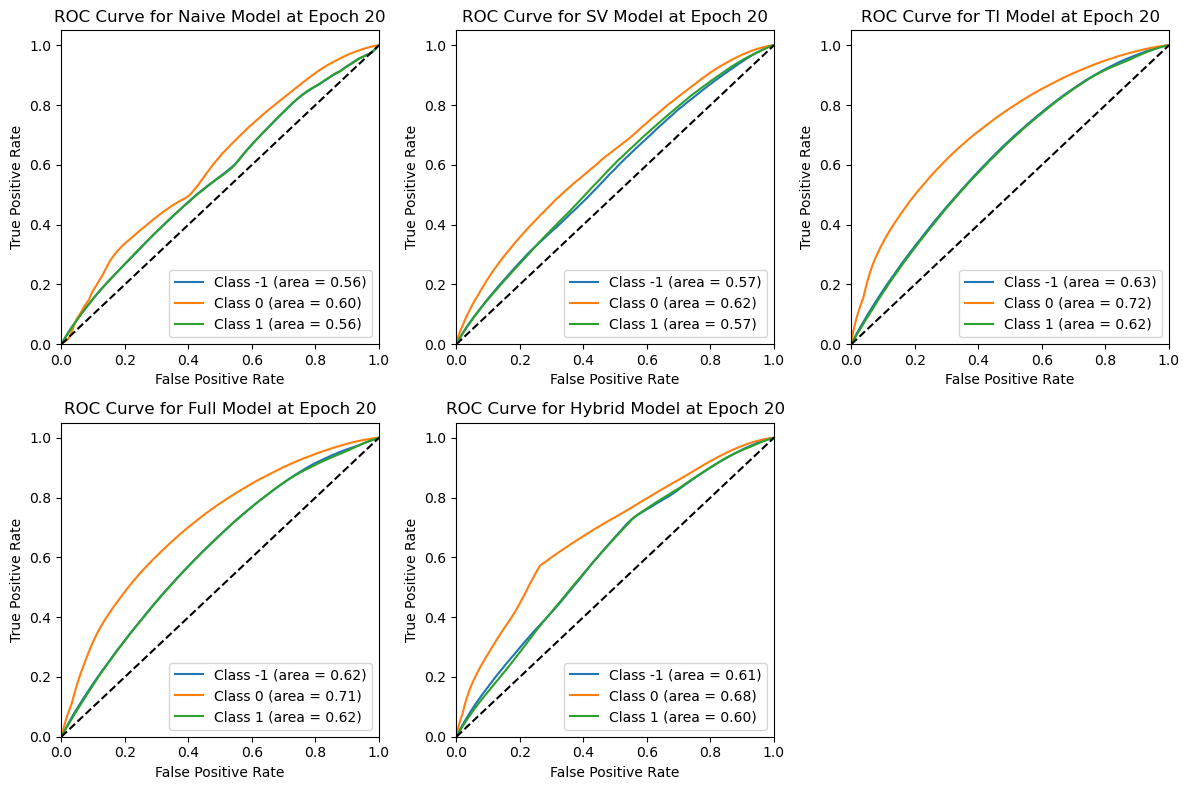

In [278]:



plot_roc_curves(results, y_test, epochs_list)

# end
